In [1]:
# ./ASVspoof2017_V2_train/T_1000001.wav

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tqdm import tqdm

In [3]:
# # Path to dataset and labels
# data_path = './ASVspoof2017_V2_train/'
# train_labels_file = 'ASVspoof2017_V2_train.trn.txt'

# # Read labels
# df = pd.read_csv(train_labels_file, sep=' ', header=None)
# df.columns = ['file', 'label', 'speaker', 'sentence', 'ignore1', 'ignore2', 'ignore3']

In [4]:
# Step 1: Load the audio file and convert it to a Mel spectrogram
def load_audio_file(filepath, sr=22050, n_mels=128):
    audio, sr = librosa.load(filepath, sr=sr)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)  # Use keyword arguments
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to decibels
    return mel_spectrogram_db

In [5]:
# # Initialize progress bar
# tqdm.pandas(desc="Extracting features")

# # Apply feature extraction with progress bar
# df['features'] = df['file'].progress_apply(lambda x: load_audio_file(os.path.join(data_path, x)))

In [6]:
# from collections import Counter

# aaa = []
# for i in range(3014):
#     aaa.append(df['features'][i].shape)

# # Count occurrences of each unique shape
# shape_counts = Counter(aaa)

# # Convert the counter to a dictionary if you want to print it
# shape_counts_dict = dict(shape_counts)

# # If you want to see the unique shapes and their counts
# for shape, count in shape_counts_dict.items():
#     print(f"Shape: {shape}, Count: {count}")


In [7]:
# import matplotlib.pyplot as plt

# # Convert shape counts to lists and sort them
# sorted_shapes_counts = sorted(shape_counts_dict.items(), key=lambda x: x[0][1])  # Sort by the width of the shape
# shapes, counts = zip(*sorted_shapes_counts)  # Unzip into two lists

# plt.figure(figsize=(70, 6))  # Adjust size for better visibility
# plt.bar(range(len(shapes)), counts, tick_label=[str(shape) for shape in shapes])
# plt.xticks(rotation=90)
# plt.xlabel('Shape')
# plt.ylabel('Count')
# plt.title('Distribution of Mel Spectrogram Shapes (Sorted by Width)')
# plt.show()


In [8]:
import numpy as np
from scipy.ndimage import zoom

# Define your target shape
target_shape = (128, 149)  # Example target shape

def standardize_spectrogram(spectrogram, target_shape):
    current_shape = spectrogram.shape
    standardized = np.zeros(target_shape)  # Initialize a zero array for the standardized shape

    if current_shape[1] > target_shape[1]:  # Clipping
        standardized[:, :] = spectrogram[:, :target_shape[1]]
    else:  # Padding or resizing
        # Fill the standardized array with the current spectrogram
        standardized[:, :current_shape[1]] = spectrogram
    
    return standardized

# # Apply standardization
# df['standardized_features'] = df['features'].progress_apply(lambda x: standardize_spectrogram(x, target_shape))


In [9]:
# from collections import Counter

# aaa = []
# for i in range(3014):
#     aaa.append(df['standardized_features'][i].shape)

# # Count occurrences of each unique shape
# shape_counts = Counter(aaa)

# # Convert the counter to a dictionary if you want to print it
# shape_counts_dict = dict(shape_counts)

# # If you want to see the unique shapes and their counts
# for shape, count in shape_counts_dict.items():
#     print(f"Shape: {shape}, Count: {count}")

In [10]:
# # Prepare data
# X = np.array(df['standardized_features'].tolist())
# y = np.where(df['label'] == 'genuine', 0, 1)  # 0 for genuine, 1 for spoof

In [11]:
# np.save("mel_spectrogram_db_data_3000_128_149",X)
# np.save("mel_spectrogram_db_labels_3000_128_149",y)

In [12]:
import numpy as np  
X=np.load("mel_spectrogram_db_data_3000_128_149.npy")
y=np.load("mel_spectrogram_db_labels_3000_128_149.npy")

In [34]:
# Normalize X to the range [0, 1]
X_min = X.min(axis=(1, 2), keepdims=True)  # Min across time and frequency
X_max = X.max(axis=(1, 2), keepdims=True)  # Max across time and frequency
X_normalized = (X - X_min) / (X_max - X_min + 1e-8)  # Add small epsilon to avoid division by zero

# Alternatively, standardize X to have zero mean and unit variance
# X_mean = X.mean(axis=(1, 2), keepdims=True)
# X_std = X.std(axis=(1, 2), keepdims=True)
# X_normalized = (X - X_mean) / (X_std + 1e-8)

# Normalize y if necessary (for example, if y is continuous)
# Uncomment the following lines if y is continuous and needs normalization
# y_min = y.min()
# y_max = y.max()
# y_normalized = (y - y_min) / (y_max - y_min + 1e-8)

# Print shapes to verify
print("Normalized X shape:", X_normalized.shape)
print("Normalized y shape:", y.shape)  # Assuming y doesn't change in shape
print("Mean of standardized X (should be close to 0):", X_normalized.mean(axis=(1, 2)))
print("Std dev of standardized X (should be close to 1):", X_normalized.std(axis=(1, 2)))

Normalized X shape: (3014, 128, 149)
Normalized y shape: (3014,)
Mean of standardized X (should be close to 0): [0.54433218 0.67331787 0.6964269  ... 0.64178196 0.60710277 0.61931305]
Std dev of standardized X (should be close to 1): [0.34808654 0.3522116  0.36994022 ... 0.36003822 0.3368147  0.36768153]


In [49]:
a = list(X_normalized.mean(axis=(1, 2)))
for i in range(len(a)):
    a[i] = float(a[i])
print(max(a))
print(min(a))

0.8531887745705824
0.1083667872438147


In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Step 2: Build a simple CNN model for classification (for illustration)
def build_cnn_model(input_shape):
    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [16]:
# Step 3: Function to apply Grad-CAM
def apply_grad_cam(model, spectrogram, layer_name='conv2d_2'):  # Use the last conv layer
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(spectrogram)
        loss = predictions[:, 0]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)[0]
    
    # Compute Grad-CAM
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = np.dot(conv_outputs, pooled_grads)

    # Apply ReLU to remove negative values and normalize
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

In [17]:
# Step 4: Plot the Grad-CAM heatmap
def plot_grad_cam(heatmap, original_spectrogram):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_spectrogram, aspect='auto', origin='lower')
    plt.title('Mel Spectrogram')
    plt.subplot(1, 2, 2)
    plt.imshow(original_spectrogram, aspect='auto', origin='lower')
    plt.imshow(heatmap, cmap='jet', alpha=0.6, aspect='auto', origin='lower')
    plt.title('Grad-CAM Heatmap')
    plt.show()

In [18]:
# Example usage
filepath = './ASVspoof2017_V2_train/T_1000001.wav'  # Replace with the path to your audio file

# Load audio file and convert to Mel spectrogram
mel_spectrogram_db = load_audio_file(filepath)
mel_spectrogram_db = standardize_spectrogram(mel_spectrogram_db, target_shape)
input_spectrogram = np.expand_dims(mel_spectrogram_db, axis=[0, -1])  # Add batch and channel dimensions

input_shape = (mel_spectrogram_db.shape[0], mel_spectrogram_db.shape[1], 1)

In [19]:
# Step 4: Plot the Grad-CAM heatmap
def plot_grad_cam_mean(heatmap, original_spectrogram):
    # Average the heatmap across the third dimension to reduce it to 2D
    heatmap = np.mean(heatmap, axis=-1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_spectrogram, aspect='auto', origin='lower')
    plt.title('Mel Spectrogram')

    plt.subplot(1, 2, 2)
    plt.imshow(original_spectrogram, aspect='auto', origin='lower')
    plt.imshow(heatmap, cmap='jet', alpha=0.6, aspect='auto', origin='lower')
    plt.title('Grad-CAM Heatmap')
    plt.show()

In [20]:
input_shape

(128, 149, 1)

In [21]:
# Build and train the CNN model
model = build_cnn_model(input_shape)

In [22]:
# Train the model (Assume you have train and labels data)
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
76/76 [==============================] - 12s 24ms/step - loss: 0.7458 - accuracy: 0.5301
Epoch 2/10
76/76 [==============================] - 1s 20ms/step - loss: 0.6699 - accuracy: 0.5819
Epoch 3/10
76/76 [==============================] - 1s 19ms/step - loss: 0.5808 - accuracy: 0.6939
Epoch 4/10
76/76 [==============================] - 2s 20ms/step - loss: 0.4114 - accuracy: 0.8283
Epoch 5/10
76/76 [==============================] - 2s 20ms/step - loss: 0.1508 - accuracy: 0.9639
Epoch 6/10
76/76 [==============================] - 1s 20ms/step - loss: 0.0632 - accuracy: 0.9859
Epoch 7/10
76/76 [==============================] - 1s 20ms/step - loss: 0.0398 - accuracy: 0.9909
Epoch 8/10
76/76 [==============================] - 1s 19ms/step - loss: 0.0257 - accuracy: 0.9954
Epoch 9/10
76/76 [==============================] - 2s 20ms/step - loss: 0.0315 - accuracy: 0.9938
Epoch 10/10
76/76 [==============================] - 1s 20ms/step - loss: 0.0126 - accuracy: 0.9979


In [53]:
import datetime

# Get the current date and time
current_time = datetime.datetime.now()

# Format the date and time
formatted_time = current_time.strftime("%d_%m_%Y_%I_%M_%p")

# Create a model name using the formatted time
model_name = f"model_{formatted_time}.h5"  # Example for a Keras model

# Print or save the model
print(f"Model will be saved as: {model_name}")

# Save your model here (example using Keras)
# model.save(model_name)  # Uncomment this line to save your model

Model will be saved as: model_01_10_2024_04_12_AM.h5


In [23]:
test_data = X_test 
test_labels = y_test
# Step 1: Test the model
test_loss, test_accuracy = model.evaluate(test_data, test_labels)

19/19 [==============================] - 1s 16ms/step - loss: 0.0675 - accuracy: 0.9735


In [24]:
# Step 2: Get model predictions
y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.5).astype(int)  # For binary classification

19/19 [==============================] - 0s 6ms/step


In [25]:
# Step 3: Compute and print classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_labels, y_pred_classes))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       321
           1       1.00      0.95      0.97       282

    accuracy                           0.97       603
   macro avg       0.98      0.97      0.97       603
weighted avg       0.97      0.97      0.97       603



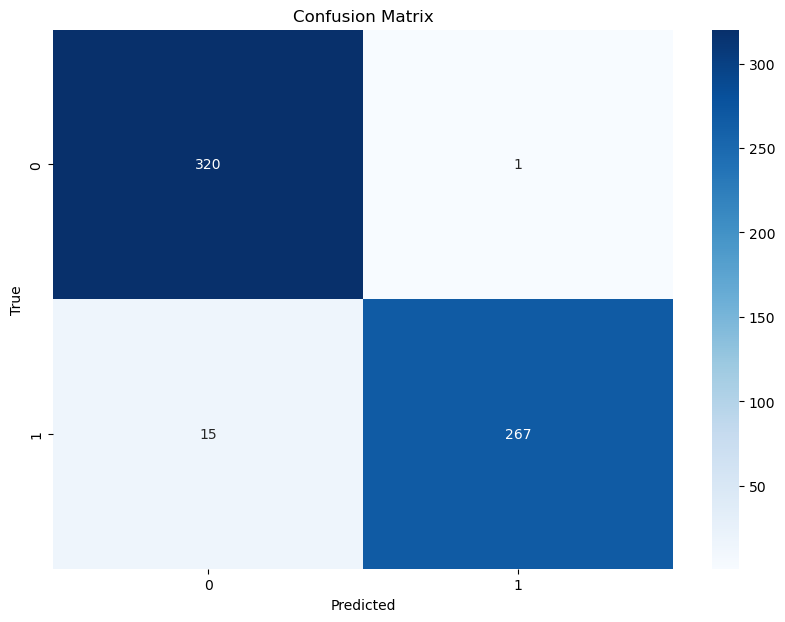

In [26]:
# Step 4: Visualize confusion matrix
cm = confusion_matrix(test_labels, y_pred_classes)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Step 5: ROC-AUC score for binary classification
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(test_labels, y_pred)
print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.9995912595833057


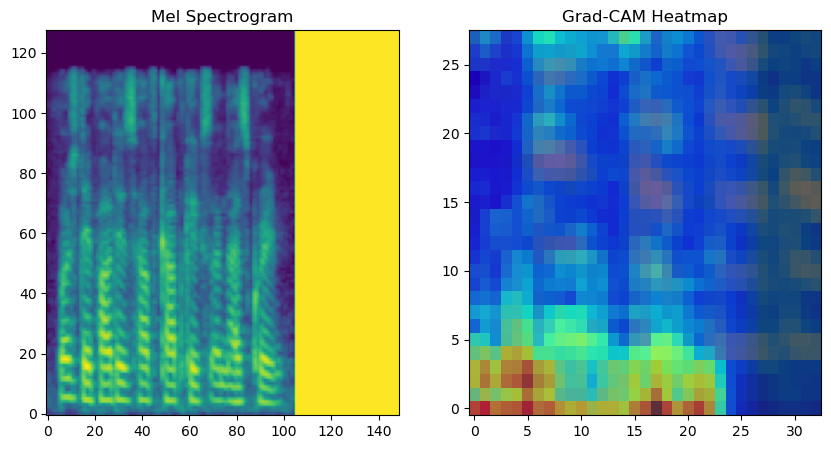

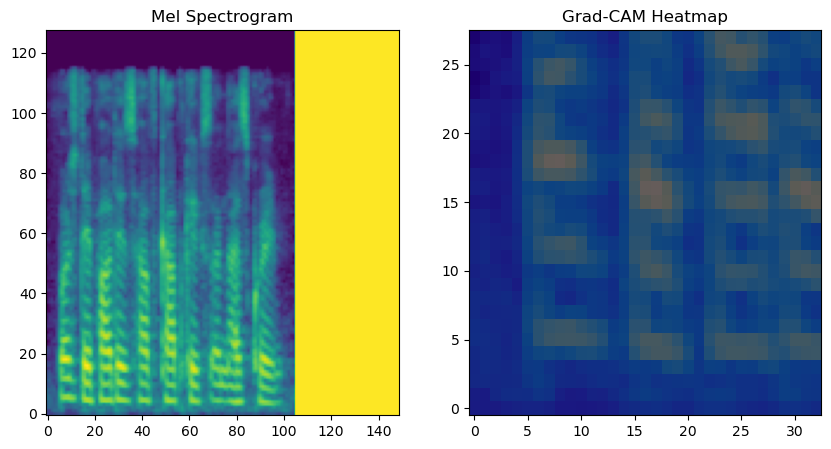

In [28]:
# Apply Grad-CAM
heatmap = apply_grad_cam(model, input_spectrogram)

# Plot the results
plot_grad_cam_mean(heatmap, mel_spectrogram_db)
# Plot the results
plot_grad_cam(heatmap[:, :, 111], mel_spectrogram_db)

In [29]:
heatmap.shape

(28, 33, 128)

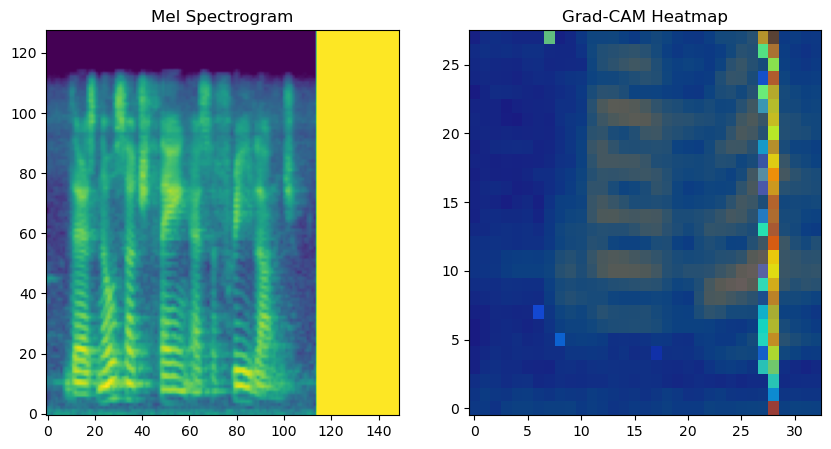

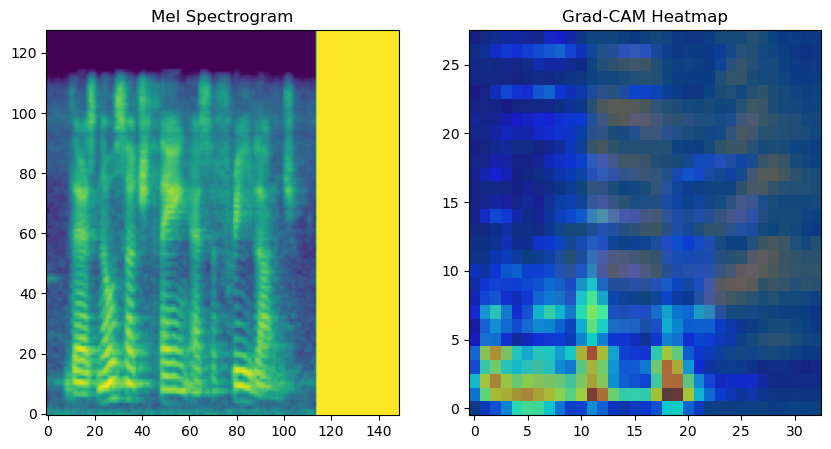

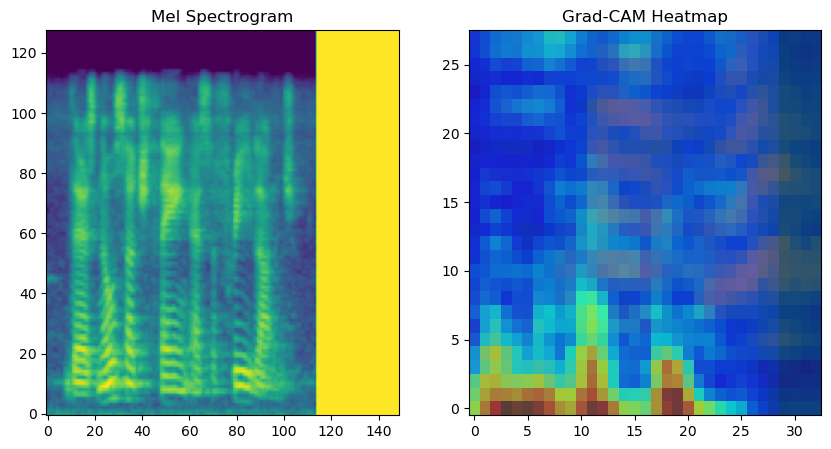

In [51]:
mel_spectrogram_db = X_test[2]
input_spectrogram_test = np.expand_dims(mel_spectrogram_db, axis=[0, -1])  # Add batch and channel dimensions
# Apply Grad-CAM
heatmap = apply_grad_cam(model, input_spectrogram_test)

# Plot the results
plot_grad_cam(heatmap[:,:,121], mel_spectrogram_db)
plot_grad_cam(heatmap[:,:,100], mel_spectrogram_db)
plot_grad_cam_mean(heatmap, mel_spectrogram_db)

In [31]:
import numpy as np

data = heatmap

# Check if all 128 slices are the same
unique_slices = np.unique(data, axis=2)

if unique_slices.shape[2] == 1:
    print("All 128 slices are the same.")
else:
    print("The 128 slices are different.")

The 128 slices are different.


In [32]:
# Select the reference slice (for example, the first slice)
reference_slice = data[:, :, 0]

# Find the indices of the slices that are different
different_slices = []

for i in range(data.shape[2]):
    if not np.array_equal(data[:, :, i], reference_slice):
        different_slices.append(data[:, :, i])

# Convert to a single NumPy array if there are differences
if different_slices:
    different_slices_array = np.stack(different_slices, axis=-1)  # Shape (28, 33, number_of_different_slices)
    print(f"Different slices shape: {different_slices_array.shape}")
else:
    print("All slices are the same as the reference slice.")

Different slices shape: (28, 33, 127)
